In [4]:
# folder to binary
import os
import pickle
import lzma
import gzip
import zstandard as zstd
import pyzipper

def read_files_in_folder(folder_path):
    files_data = {}
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            with open(file_path, 'rb') as f:
                relative_path = os.path.relpath(file_path, folder_path)
                files_data[relative_path] = f.read()
    return files_data

def compress_files_data(files_data):
    compressed_data = {}
    compressor = zstd.ZstdCompressor()
    for file_path, file_content in files_data.items():
        compressed_data[file_path] = compressor.compress(file_content)
    return compressed_data

def save_compressed_data(compressed_data, output_file):
    with open(output_file, 'wb') as f:
        pickle.dump(compressed_data, f)

def folder_to_binary(folder_path, binary_file_path):
    files_data = read_files_in_folder(folder_path)
    compressed_data = compress_files_data(files_data)
    save_compressed_data(compressed_data, binary_file_path)

def bin_file_to_bitstring(file_path):
    with open(file_path, 'rb') as file:
        byte_data = file.read()
        bitstring = ''.join(format(byte, '08b') for byte in byte_data)
    return bitstring

def save_bitstring_to_text_file(bitstring, text_file_path):
    with open(text_file_path, 'w') as file:
        file.write(bitstring)

if __name__ == "__main__":
    
    input_folder_path = r'D:\Shozy\trm2\GP\msgs'
    folder_to_binary(input_folder_path,'folder_metadata.bin')
    # Convert a binary file to a bitstring
    bitstring = bin_file_to_bitstring('folder_metadata.bin')
    print(f'Bitstring: {bitstring}')

    # Save the bitstring to a text file
    save_bitstring_to_text_file(bitstring, 'folder_binary.bin')
    print('Bitstring saved to text file')


Bitstring: 10000000000000110111110101110001000000000010100001011000000001010000000000000000000000000011000100101110011101000111100001110100011100010000000101000011011000110010100010110101001011111111110100100000110010001101010100000010000000001101100000110000001100010011000000100000001100000011000100110000001000000011000000110001001100010011000100110000001100010010000000110000001100010011000100110000001100000011000000110001001100000011000000110000000011010000101000011011000000000100000000001000110010000111011111010100000010000101011000000001110000000000010011000000101111010010010101010000000110000001010100000000110000011011110111010001101100011000011100000101001110000110110010000000101010101011100010101100001110001000010000110010000000001101101010110000001110001101000011101010000000010101001000000010001111100000111110010010101100101000000011010100100000001001111010010111101100000010010001101001011010010111100001000101010010001001011111000011000000100111000100000010010110000000010100000

M: 237 N: 300 max_capacity_bits: 284400
Threshold: 0.20, Number of Edge Pixels: 65858, Required Blocks: 6608
M: 237 N: 300 max_capacity_bits: 284400
Threshold: 0.20, Number of Edge Pixels: 66102, Required Blocks: 6608
M: 237 N: 300 max_capacity_bits: 284400
Threshold: 0.20, Number of Edge Pixels: 64401, Required Blocks: 6608
All data embedded successfully. Data index: 26432, Data length: 26432
All data embedded successfully. Data index: 26432, Data length: 26432
All data embedded successfully. Data index: 26432, Data length: 26432
All data extracted successfully. Extracted length: 26432, Expected length: 26432
All data extracted successfully. Extracted length: 26432, Expected length: 26432
All data extracted successfully. Extracted length: 26432, Expected length: 26432
Verification Result: True
Bit String Comparison Result: True


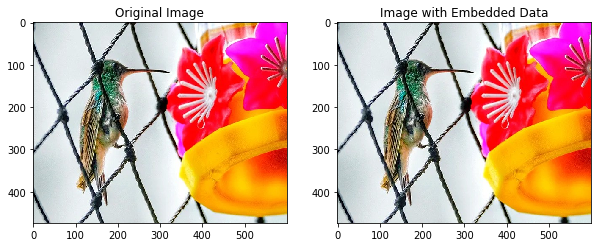

In [5]:
import numpy as np
import cv2
from scipy.ndimage import convolve
import matplotlib.pyplot as plt

def compute_gradients(image):
    Kx = np.array([[-1, 1], [-1, 1]])  # 2D kernel for x-gradient
    Ky = np.array([[-1, -1], [1, 1]])  # 2D kernel for y-gradient
    Gx = convolve(image, Kx)
    Gy = convolve(image, Ky)
    return Gx, Gy

def compute_magnitude_and_angle(Gx, Gy):
    G = np.sqrt(Gx**2 + Gy**2)
    theta = np.arctan2(Gy, Gx) * 180 / np.pi  # Convert to degrees
    return G, theta

def normalize_magnitude(G):
    G_max = np.max(G)
    Gn = G / G_max if G_max != 0 else G
    return Gn

def quantize_angle(theta):
    angle_quantization = np.zeros_like(theta)
    theta = np.mod(theta + 180, 180)  # Normalize angles to [0, 180)
    angle_quantization[(theta >= 0) & (theta < 45)] = 1
    angle_quantization[(theta >= 45) & (theta < 90)] = 2
    angle_quantization[(theta >= 90) & (theta < 135)] = 3
    angle_quantization[(theta >= 135) & (theta < 180)] = 4
    return angle_quantization

def compute_hog(image, block_size=2):
    M, N = image.shape
    Gx, Gy = compute_gradients(image)
    G, theta = compute_magnitude_and_angle(Gx, Gy)
    Gn = normalize_magnitude(G)
    theta_q = quantize_angle(theta)
    
    # Ensure M and N are divisible by block_size
    M_pad = (block_size - M % block_size) % block_size
    N_pad = (block_size - N % block_size) % block_size
    Gn_padded = np.pad(Gn, ((0, M_pad), (0, N_pad)), mode='constant')
    theta_q_padded = np.pad(theta_q, ((0, M_pad), (0, N_pad)), mode='constant')
    
    M_padded, N_padded = Gn_padded.shape
    hog = np.zeros((M_padded // block_size, N_padded // block_size, 4))
    
    for i in range(0, M_padded, block_size):
        for j in range(0, N_padded, block_size):
            block_magnitude = Gn_padded[i:i+block_size, j:j+block_size]
            block_angle = theta_q_padded[i:i+block_size, j:j+block_size]
            for q in range(1, 5):
                hog[i // block_size, j // block_size, q - 1] = np.sum(block_magnitude[block_angle == q])
    return hog

def find_blocks_of_interest(hog, secret_message_length, initial_threshold=0.2, increment=0.02):
    M, N, _ = hog.shape
    total_blocks = M * N  # Number of 2x2 blocks
    max_capacity = total_blocks * 4  # Each 2x2 block can store 4 bits
    max_capacity_bits = max_capacity  # Capacity in bits
    print("M:", M, "N:", N, "max_capacity_bits:", max_capacity_bits)
    
    if secret_message_length > max_capacity_bits:
        raise ValueError(f"Secret message is too large to be embedded in the cover image. Maximum capacity is {max_capacity_bits} bits.")
    
    T = initial_threshold  # Start with a higher initial threshold value
    while T <= 1.0:
        dominant_magnitude = np.max(hog, axis=2)
        BOI = dominant_magnitude > T
        Ne = np.sum(BOI)
        print(f"Threshold: {T:.2f}, Number of Edge Pixels: {Ne}, Required Blocks: {secret_message_length // 4}")
        if Ne * 4 >= secret_message_length:
            break
        T += increment

    if T > 1.0:
        print("Warning: T exceeded 1.0 before finding sufficient blocks.")
    
    # # Visualization for debugging
    # plt.figure(figsize=(12, 6))
    # plt.subplot(1, 2, 1)
    # plt.title("Dominant Magnitude")
    # plt.imshow(dominant_magnitude, cmap='hot')
    # plt.colorbar()
    # plt.subplot(1, 2, 2)
    # plt.title("Blocks of Interest")
    # plt.imshow(BOI, cmap='gray')
    # plt.show()
    
    return BOI, T

def file_to_bit_string(file_path):
    with open(file_path, 'rb') as file:
        byte_data = file.read()
    binary_string = ''.join(format(byte, '08b') for byte in byte_data)
    return binary_string

def bit_string_to_file(bit_string, output_path):
    if len(bit_string) % 8 != 0:
        raise ValueError("Bit string length should be a multiple of 8.")
    byte_array = bytearray(int(bit_string[i:i+8], 2) for i in range(0, len(bit_string), 8))
    with open(output_path, 'wb') as file:
        file.write(byte_array)

def pvd_lsb_embed(image, BOI, bit_secret_data):
    data_index = 0
    data_length = len(bit_secret_data)

    embedded_image = image.copy()
    M, N = embedded_image.shape

    for i in range(0, M, 2):
        for j in range(0, N, 2):
            if i + 2 > M or j + 2 > N:
                continue  # Skip blocks that are out of bounds
            if BOI[i // 2, j // 2] and data_index < data_length:
                block = embedded_image[i:i+2, j:j+2].astype(np.int32)
                if data_index + 2 <= data_length:
                    p1, p2 = block[0, 1], block[1, 0]
                    diff = p2 - p1
                    secret_bits = bit_secret_data[data_index:data_index + 2]
                    secret_value = int(secret_bits, 2)
                    if diff < 0:
                        secret_value = -secret_value
                    new_p2 = np.clip(p1 + secret_value, 0, 255)
                    block[1, 0] = new_p2
                    data_index += 2
                for x in range(2):
                    for y in range(2):
                        if (x, y) != (0, 1) and (x, y) != (1, 0) and data_index < data_length:
                            pixel_value = block[x, y]
                            lsb_value = int(bit_secret_data[data_index])
                            block[x, y] = (pixel_value & ~1) | lsb_value
                            data_index += 1

                embedded_image[i:i+2, j:j+2] = block.astype(np.uint8)

    if data_index < data_length:
        print(f"Warning: Not all data was embedded. Data index: {data_index}, Data length: {data_length}")
    else:
        print(f"All data embedded successfully. Data index: {data_index}, Data length: {data_length}")

    return embedded_image

def pvd_lsb_extract(image, BOI, message_length):
    bit_data = []
    data_index = 0
    extracted_message_length = message_length

    M, N = image.shape

    for i in range(0, M, 2):
        for j in range(0, N, 2):
            if i + 2 > M or j + 2 > N:
                continue  # Skip blocks that are out of bounds
            if BOI[i // 2, j // 2] and data_index < extracted_message_length:
                block = image[i:i+2, j:j+2].astype(np.int32)
                if data_index + 2 <= extracted_message_length:
                    p1, p2 = block[0, 1], block[1, 0]
                    diff = p2 - p1
                    secret_value = abs(diff)
                    secret_bits = format(secret_value, '02b')
                    bit_data.extend(secret_bits)
                    data_index += 2
                for x in range(2):
                    for y in range(2):
                        if (x, y) != (0, 1) and (x, y) != (1, 0) and data_index < extracted_message_length:
                            pixel_value = block[x, y]
                            lsb_value = pixel_value & 1
                            bit_data.append(str(lsb_value))
                            data_index += 1

    bit_string = ''.join(bit_data)

    if len(bit_string) < extracted_message_length:
        print(f"Warning: Extracted message is shorter than expected. Extracted length: {len(bit_string)}, Expected length: {extracted_message_length}")
    else:
        print(f"All data extracted successfully. Extracted length: {len(bit_string)}, Expected length: {extracted_message_length}")

    return bit_string[:message_length]

def verify_data(file1, file2):
    with open(file1, 'rb') as f1, open(file2, 'rb') as f2:
        data1 = f1.read()
        data2 = f2.read()
    return data1 == data2

def compare_bit_strings(original, extracted):
    for i in range(len(original)):
        if original[i] != extracted[i]:
            print(f"Mismatch at position {i}: original={original[i]}, extracted={extracted[i]}")
            print(f"Original data surrounding mismatch: {original[i-10:i+10]}")
            print(f"Extracted data surrounding mismatch: {extracted[i-10:i+10]}")
            return False
    return True

def process_rgb_image(image, func, *args):
    channels = list(cv2.split(image))
    results = []
    for channel in channels:
        result = func(channel, *args)
        results.append(result)
    return results

def process_image(image_path, binary_file_path):
    # Load the example image (RGB)
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image at path '{image_path}' could not be loaded. Please check the path and try again.")

    # Read binary file and convert to bit string
    bit_secret_data = file_to_bit_string(binary_file_path)
    secret_message_length = len(bit_secret_data)

    # Compute HOG and find BOI with adaptive thresholding for each channel
    hogs = process_rgb_image(image, compute_hog)
    BOIs = [find_blocks_of_interest(hog, secret_message_length, initial_threshold=0.2, increment=0.02)[0] for hog in hogs]

    # Embed the bit secret data in each channel
    embedded_image = image.copy()
    channels = list(cv2.split(embedded_image))
    for i, channel in enumerate(channels):
        BOI = BOIs[i]
        channel_embedded = pvd_lsb_embed(channel, BOI, bit_secret_data)
        channels[i] = channel_embedded
    embedded_image = cv2.merge(channels)

    # Extract the bit secret data from each channel
    extracted_bit_strings = []
    channels = list(cv2.split(embedded_image))
    for i, channel in enumerate(channels):
        BOI = BOIs[i]
        extracted_bit_string = pvd_lsb_extract(channel, BOI, secret_message_length)
        extracted_bit_strings.append(extracted_bit_string)

    # Combine extracted bit strings (if necessary)
    # For simplicity, assuming the data is embedded in the first channel
    extracted_bit_string = extracted_bit_strings[0]

    bit_string_to_file(extracted_bit_string, 'extracted_file_bin.bin')

    # Verify that the contents of the embedded data are the same as the extracted data
    is_verified = verify_data(binary_file_path, 'extracted_file_bin.bin')
    print("Verification Result:", is_verified)

    # Perform bit-by-bit comparison of the bit strings
    comparison_result = compare_bit_strings(bit_secret_data, extracted_bit_string)
    print("Bit String Comparison Result:", comparison_result)

    # Display the original and embedded images
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    plt.subplot(1, 2, 2)
    plt.title("Image with Embedded Data")
    plt.imshow(cv2.cvtColor(embedded_image, cv2.COLOR_BGR2RGB))

    plt.show()

# Example usage with the uploaded image and a binary file path
process_image('3.jpg', 'folder_binary.bin')


In [6]:
#binary to folder
import os
import gzip
import lzma
import zstandard as zstd
import pyzipper
import pickle

def decompress_files_data(compressed_data):
    files_data = {}
    decompressor = zstd.ZstdDecompressor()
    for file_path, file_content in compressed_data.items():
        files_data[file_path] = decompressor.decompress(file_content)
    return files_data

def save_files(files_data, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for file_path, file_content in files_data.items():
        full_path = os.path.join(output_folder, file_path)
        os.makedirs(os.path.dirname(full_path), exist_ok=True)
        with open(full_path, 'wb') as f:
            f.write(file_content)

def binary_to_folder(binary_file_path, output_folder):
    with open(binary_file_path, 'rb') as f:
        compressed_data = pickle.load(f)
    files_data = decompress_files_data(compressed_data)
    save_files(files_data, output_folder)

def read_bitstring_from_text_file(text_file_path):
    with open(text_file_path, 'r') as file:
        bitstring = file.read()
    return bitstring

def bitstring_to_bin_file(bitstring, output_path):
    byte_data = bytearray(int(bitstring[i:i+8], 2) for i in range(0, len(bitstring), 8))
    with open(output_path, 'wb') as file:
        file.write(byte_data)
        
# Example usage
if __name__ == "__main__":
    bitstring_from_text = read_bitstring_from_text_file('extracted_file_bin.bin')
    print('Bitstring read from text file')
    bitstring_to_bin_file(bitstring_from_text, 'folder_metadata_retrieved.bin')
    print('Conversion back to binary file completed')
    binary_to_folder('folder_metadata_retrieved.bin', 'extracted_folder')

Bitstring read from text file
Conversion back to binary file completed


In [2]:
import os
print(os.getcwd())

d:\Shozy\trm2\GP\papersss
